In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cdcp.paths import DATA_DIR
from tqdm import tqdm

In [ ]:
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic

In [ ]:
bird_folders = list(
    #(DATA_DIR / "behavior" / "interp_prediction_behavior_csvs").glob("B*")
    (DATA_DIR / "TS-231215-B1591-B1590").glob("B*")
    
)

In [ ]:
bird_folders

In [ ]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig
SAVE_FIGS = True

In [ ]:
import json

def js_r(filename: str):
    with open(filename) as f_in:
        return json.load(f_in)

In [ ]:
js_r(bird_folders[0] / 'config.json')

In [ ]:
interp_range = np.arange(48,80)
interp_range

### Load data

In [9]:
# Specify the date you want to compare against
target_date = np.datetime64('2023-12-01')

In [10]:
behav_data = {}
for bird in bird_folders:
    
    if bird.is_dir() == False:
        continue
    print(bird)
    behavior_csvs = list(bird.glob("*.csv"))
    behav_data[bird.stem] = pd.concat(
        [pd.read_csv(behavior_csv) for behavior_csv in behavior_csvs]
    )
    behav_data[bird.stem] = behav_data[bird.stem][
        behav_data[bird.stem].type_ == "normal"
    ]
    behav_data[bird.stem]['time'] = pd.to_datetime(behav_data[bird.stem]['time'])

    behav_data[bird.stem] = behav_data[bird.stem].sort_values(by='time')
    behav_data[bird.stem]['correct_bool'] = behav_data[bird.stem].correct == True
    
    # only get most recent data
    behav_data[bird.stem] = behav_data[bird.stem][behav_data[bird.stem].time.values > target_date]
    
    print(len(behav_data[bird.stem]))
    #behav_data[bird.stem] = behav_data[bird.stem][10000:]
    #print(len(behav_data[bird.stem]))
    
    # bin
    bin_edges = np.linspace(0, 127, 32 + 1)

    behav_data[bird.stem]['pos_bin'] = np.digitize(behav_data[bird.stem].interpolation_point.values, bin_edges)
    
    behav_data[bird.stem] = behav_data[bird.stem][behav_data[bird.stem].cueing == True]
    behav_data[bird.stem] = behav_data[bird.stem][behav_data[bird.stem].response != "none"]

    behav_data[bird.stem]["response_bool"] = behav_data[bird.stem].response == "left"
    behav_data[bird.stem]["interp"] = [i + j for i, j in zip(behav_data[bird.stem].left_stim.values, behav_data[bird.stem].right_stim.values)]

/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/TS-231215-B1591-B1590/B1590
6585
/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/TS-231215-B1591-B1590/B1591


/tmp/ipykernel_18346/478466596.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(behavior_csv) for behavior_csv in behavior_csvs]


6178


In [11]:
birds = list(behav_data.keys())

### Describe data

In [12]:
print(birds, [len(behav_data[i]) for i in birds])

['B1590', 'B1591'] [6499, 5962]


In [13]:
cue_count_df = pd.DataFrame(np.unique(behav_data[birds[0]].cue_class.values, return_counts=True)).T
cue_count_df.columns = ['cue', 'count']
cue_count_df['prop'] = cue_count_df['count'] / np.sum(cue_count_df['count'])
cue_count_df

,cue,count,prop
0,CL0,1730,0.266195
1,CL1,1718,0.264348
2,CN,620,0.095399
3,CR0,1828,0.281274
4,NC,603,0.092784


In [14]:
len(behav_data[birds[0]].interpolation_point.unique())

32

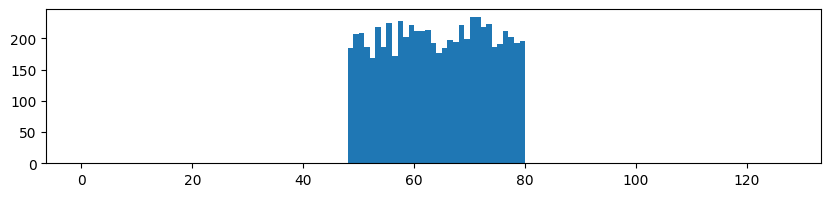

In [15]:
fig, ax = plt.subplots(figsize=(10,2))
ax.hist(behav_data[birds[0]].interpolation_point.values, bins = np.arange(128));

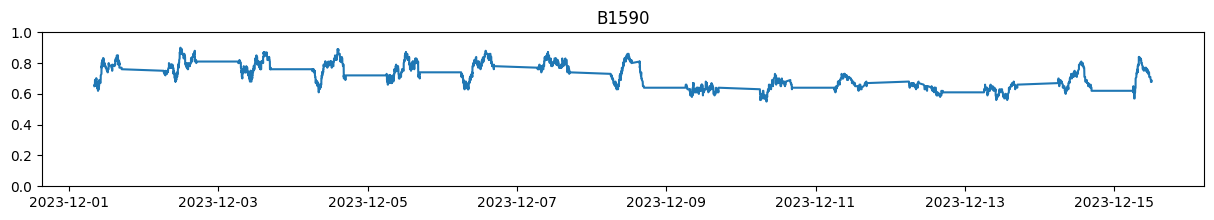

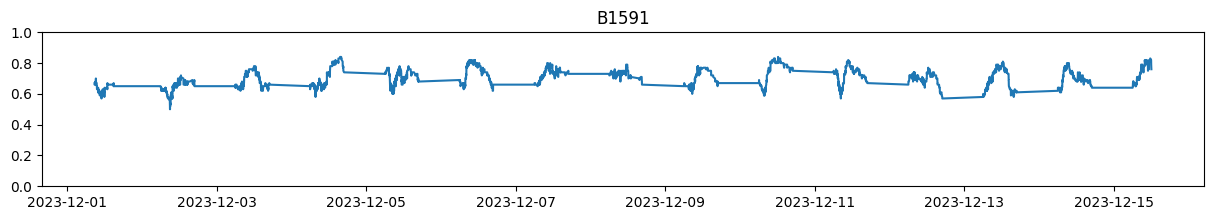

In [16]:
for bird in birds:
    fig, ax = plt.subplots(figsize=(15,2))
    ax.plot(
        behav_data[bird].time.values, 
        behav_data[bird].correct_bool.rolling(100).mean()
    )
    ax.set_ylim([0,1])
    ax.set_title(bird)

In [17]:
count_dfs = []
for cue in behav_data[birds[0]].cue_class.unique():
    count_df = pd.DataFrame(np.unique(behav_data[birds[0]][behav_data[birds[0]].cue_class == cue].interp.values, return_counts=True)).T
    count_df.columns = ['interp', 'count']
    count_df['prop'] = count_df['count'] / np.sum(count_df['count'].values)
    count_df['cue'] = cue
    count_dfs.append(count_df)
count_df = pd.concat(count_dfs)

In [18]:
count_df[:3]

,interp,count,prop,cue
0,AE,166,0.09081,CR0
1,BF,186,0.101751,CR0
2,CG,1476,0.80744,CR0


In [19]:
import seaborn as sns

<Axes: xlabel='cue', ylabel='count'>

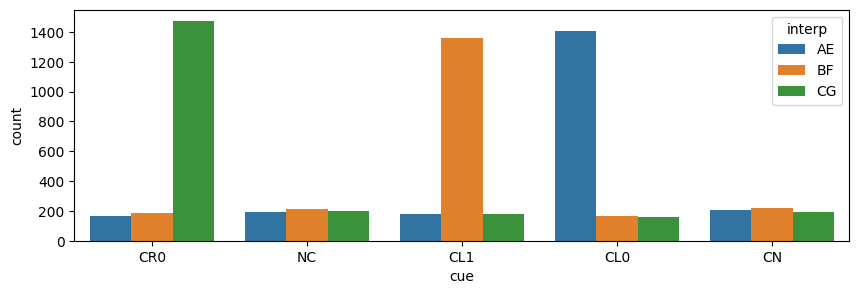

In [20]:
fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x='cue', y='count', hue='interp', data=count_df, ax = ax)

<Axes: xlabel='cue', ylabel='prop'>

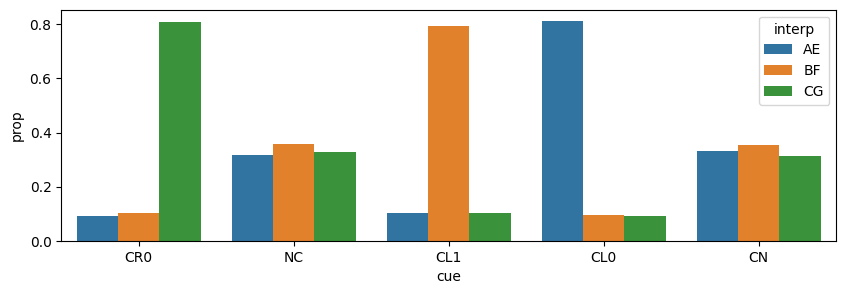

In [21]:
fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x='cue', y='prop', hue='interp', data=count_df, ax = ax)

In [22]:
count_df

,interp,count,prop,cue
0,AE,166,0.09081,CR0
1,BF,186,0.101751,CR0
2,CG,1476,0.80744,CR0
0,AE,190,0.315091,NC
1,BF,216,0.358209,NC
2,CG,197,0.3267,NC
0,AE,176,0.102445,CL1
1,BF,1363,0.793364,CL1
2,CG,179,0.104191,CL1
0,AE,1407,0.813295,CL0


In [23]:
cue_map = {
    "AE": "CL0",
    "BF": "CL1",
    "CG": "CR0",
}

### Is the bird more accurate in the cued condition
### Is the decision boundary sharper in the cued condition
- for each bird, for each interpolation, split data into cued and uncued
- compute accuracy
- compute psychometric
- plot accuracy differences
- plot inflection point differences

In [24]:
for bird in birds:
    behav_data[bird]['bird'] = bird
behav_data_all = pd.concat([behav_data[bird] for bird in birds])
behav_data_all = behav_data_all[behav_data_all.type_ == 'normal']
behav_data_all = behav_data_all[['bird', 'interp', 'pos_bin', 'cue_id', 'response', 'correct', 'rt']]

In [25]:
behav_data_all['cue_condition'] = None
behav_data_all['cue_probability'] = None
for morph, cue in cue_map.items():
    behav_data_all.loc[(behav_data_all.cue_id == cue) & (behav_data_all.interp == morph), 'cue_condition'] = 'high_prob'
    behav_data_all.loc[(behav_data_all.cue_id == cue) & (behav_data_all.interp != morph), 'cue_condition'] =  'low_prob'
    behav_data_all.loc[(behav_data_all.cue_id == cue) & (behav_data_all.interp == morph), 'cue_probability'] = 0.8
    behav_data_all.loc[(behav_data_all.cue_id == cue) & (behav_data_all.interp != morph), 'cue_probability'] = 0.1
behav_data_all.loc[(behav_data_all.cue_id == 'NC'), 'cue_condition'] = 'uncued'
behav_data_all.loc[(behav_data_all.cue_id == 'NC'), 'cue_probability'] = 0.1 / 3
behav_data_all.loc[(behav_data_all.cue_id == 'CN'), 'cue_condition'] = 'middle_prob'
behav_data_all.loc[(behav_data_all.cue_id == 'CN'), 'cue_probability'] = 1 / 3

In [26]:
behav_data_all.response.unique()

array(['right', 'left'], dtype=object)

In [27]:
from scipy.stats import pearsonr

In [28]:
pearsonr(behav_data_all.correct.values, behav_data_all.cue_probability.values), len(behav_data_all.correct.values)

(PearsonRResult(statistic=0.054949810017272935, pvalue=8.356358459191918e-10),
 12461)

In [29]:
behav_data_all[:3]

,bird,interp,pos_bin,cue_id,response,correct,rt,cue_condition,cue_probability
865,B1590,CG,18,CR0,right,False,3.035127,high_prob,0.8
870,B1590,AE,13,NC,left,False,0.047696,uncued,0.033333
872,B1590,BF,14,CR0,left,False,0.157154,low_prob,0.1


In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [35]:
df = behav_data_all[['bird', 'correct', 'cue_probability']]
df['correct'] = df['correct'].astype(float)
df['cue_probability'] = df['cue_probability'].astype(float)

/tmp/ipykernel_18346/1175038176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct'] = df['correct'].astype(float)
/tmp/ipykernel_18346/1175038176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cue_probability'] = df['cue_probability'].astype(float)


In [38]:
# Define the model, treating 'unit' as a random effect
model = smf.mixedlm("correct ~ cue_probability", df, groups=df["bird"], re_formula="1 + cue_probability")
result = model.fit()

# Print the summary to see the results
print(result.summary())

/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     correct   
No. Observations:       12461       Method:                 REML      
No. Groups:             2           Scale:                  0.2008    
Min. group size:        5962        Log-Likelihood:         -7685.9276
Max. group size:        6499        Converged:              Yes       
Mean group size:        6230.5                                        
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.677    0.017 39.257 0.000  0.643  0.710
cue_probability              0.076    0.013  6.023 0.000  0.051  0.101
Group Var                    0.000                                    
Group x cue_probability Cov -0.000                                    
cue_probability Var    

In [91]:
import seaborn as sns

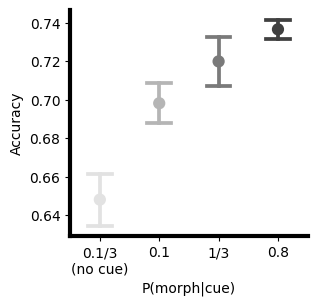

In [159]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=behav_data_all,
    x="cue_condition",
    y="correct",
    #hue="interp",
    #col="bird",
    order=["high_prob", "middle_prob", "low_prob", "uncued"][::-1],
    
    palette="Greys",
    errorbar="se",
    kind="point",
    capsize=0.4,
    height=3,
    aspect=1.1,
)
#g.despine(left=True)
ax = g.ax
#ax.set_ylim([0,6, 0.8])
ax.set_ylabel('Accuracy')
ax.set_xlabel('P(morph|cue)')
ax.set_xticklabels(
    [
        '0.1/3\n(no cue)',
        '0.1',
        '1/3',
        '0.8'
    ]
)
[i.set_linewidth(3) for i in ax.spines.values()]

if SAVE_FIGS:
    ensure_dir(FIGURE_DIR / 'cued-morph' )
    save_fig(FIGURE_DIR / 'cued-morph'/ 'cued-morph-acc', save_pdf=True)
    plt.show()

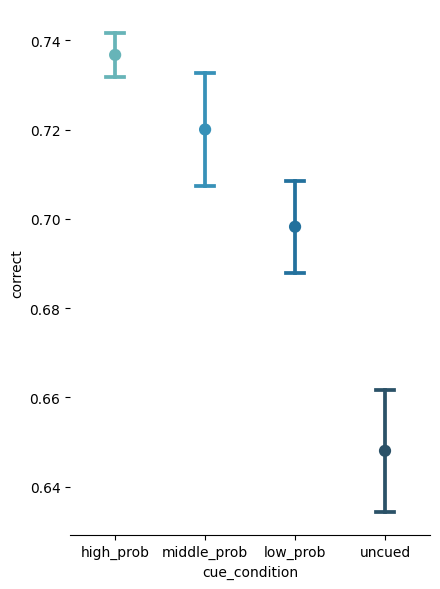

In [92]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=behav_data_all,
    x="cue_condition",
    y="correct",
    #hue="interp",
    #col="bird",
    order=["high_prob", "middle_prob", "low_prob", "uncued"],
    capsize=0.2,
    palette="YlGnBu_d",
    errorbar="se",
    kind="point",
    height=6,
    aspect=0.75,
)
g.despine(left=True)

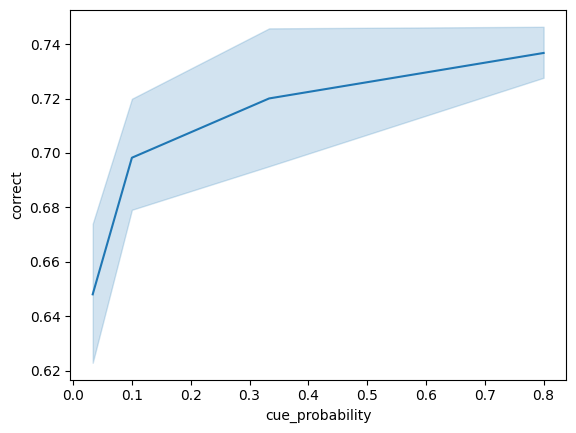

In [94]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.lineplot(
    data=behav_data_all,
    x="cue_probability",
    y="correct",
)